# 2.1 Library Setup & Data Loading

In [1]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Libraries for Automated "First Pass" Scan
from ydata_profiling import ProfileReport

In [2]:
# Libraries for Redundancy Analysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

In [2]:
# Libraries for Feature Selection
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Libraries for SHAP
import shap

In [15]:
# Libraries for Segmentation via UMAP
import umap
from sklearn.preprocessing import StandardScaler

In [5]:
# Load The Training Dataset
train_df = pd.read_parquet('../data/processed/train_df.parquet', engine='fastparquet')
print(f"Training DataFrame Shape: {train_df.shape}")

Training DataFrame Shape: (52004, 140)


# 2.2 Automated "First Pass" & Data Health

This paper discusses the necessity of automated tools to handle the "scale and complexity of modern data," which traditional manual EDA cannot.
* Gaikwad, J., et al. (2024). AI-based exploratory data analysis. International Journal of Scientific Research in Computer Science, Engineering and Information Technology, 11(2), 3876–3884. https://doi.org/10.32628/CSEIT25112860

In [3]:
# Automated Profiling Report
# Identify missing values, zeros, and high correlations instantly
profile = ProfileReport(train_df, title="Telco Churn Data Health Check", minimal=True)
profile.to_file('../reports/data_health_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:10<00:00, 13.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Check for Zero Variance
zero_var_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]

if len(zero_var_cols) == 0:
    print("Confirmed: No columns with zero variance. Every feature has data.")
else:
    print(f"Found {len(zero_var_cols)} columns with zero variance: {zero_var_cols}")

Confirmed: No columns with zero variance. Every feature has data.


### Data Profiling & Health Check Summary
**Objective:** assessed data quality, sparsity, and distribution properties.

**Key Findings:**
* **Data Integrity:** The dataset contains no missing values and no zero-variance columns.
* **Cardinality:** `customer_id` acts as a unique key and will be removed. Several continuous features (e.g., `spend_change_2wk`) exhibit 100% cardinality (unique values per user), which is expected for high-precision calculated metrics.
* **Correlations:** The initial automated scan (in minimal mode) suppressed correlation computations. **Action Taken:** A manual Spearman correlation analysis will be performed (see next section), confirming strong monotonic relationships between base app usage and aggregate data features.
* **Target Variable:** The churn rate is **23.1%**, requiring recall-oriented evaluation metrics or threshold-independent metrics (AUC-ROC) rather than accuracy.
* **Sparsity:** High-sparsity features contain ~40% zeros, supporting the use of **Weight of Evidence (WoE)** binning.
* **Distribution:** Significant skewness was observed in `distinct_services_w1_2` ($\gamma_1 \approx -131$), indicating a highly concentrated user behavior pattern that will require non-linear transformation or binning (depending on which algorithm selected).

**Action Taken:**
* Dropped identifier column (`customer_id`).
* Proceeding to **Hierarchical Clustering** to visualize feature redundancy.

# 2.3 Redundancy Analysis

These papers emphasize redundancy analysis with hierarchical flustering of features (dendrograms) to handle the curse of dimensionality
* Jambekar, P., & Nandi, S. (2022). Mitigating the multicollinearity problem and its machine learning approach: A review. Mathematics, 10(8), 1283. https://doi.org/10.3390/math10081283
* Chavent, M., Kuentz-Simonet, V., Labenne, A., & Saracco, J. (2022). Hierarchical clustering: Visualization, feature importance and model selection. Computational Statistics, 37, 1–25. https://doi.org/10.1016/j.asoc.2023.110303

In [6]:
# Drop ONLY customer_id
train_df.drop(columns=['customer_id'], inplace=True)

Manual Check: Correlation between Total Data and YouTube is: 0.5844


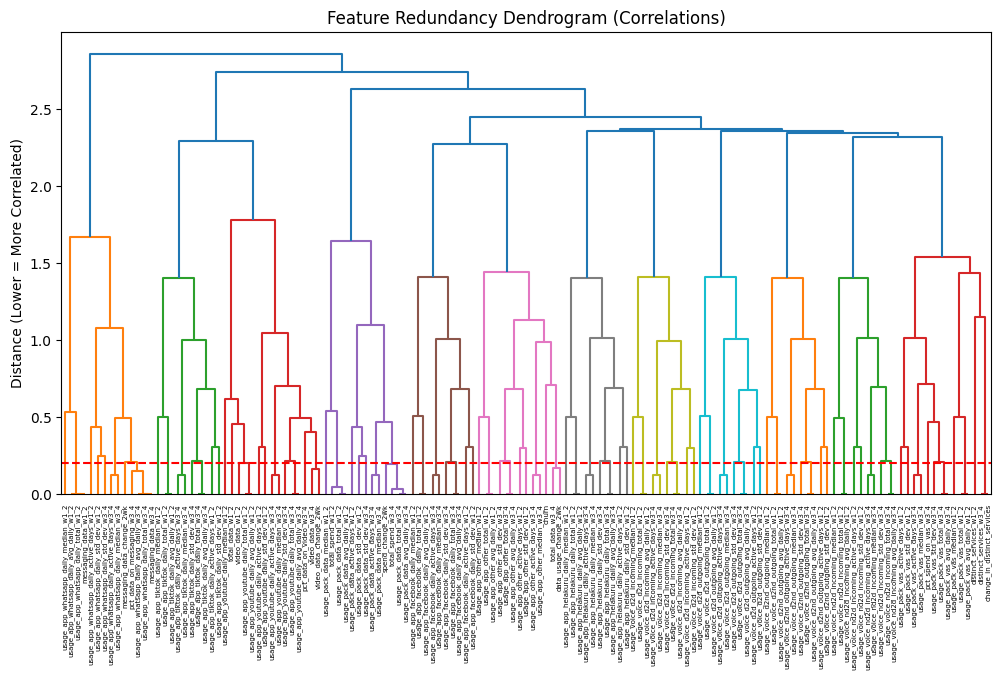

In [8]:
# Calculate Spearman Correlation
# This captures non-linear relationships better than the Profiling Report
corr_matrix = train_df.corr(method='spearman')

# Quick Logic Check:
# Verify the specific relationship between two columns with potential high correlation
check_val = corr_matrix.loc['total_data_w1_2', 'usage_app_youtube_daily_total_w1_2']
print(f"Manual Check: Correlation between Total Data and YouTube is: {check_val:.4f}")

# Visualization: Hierarchical Clustering (Dendrogram)
plt.figure(figsize=(12, 6))
# Convert correlation to distance
# If two features are not correlated at all (0), they are totally different.
# The distance should be 1 (or maximum)
dist_matrix = 1 - np.abs(corr_matrix)
clustering = linkage(squareform(dist_matrix), method='ward')

dendrogram(clustering, labels=train_df.columns, leaf_rotation=90)
plt.title("Feature Redundancy Dendrogram (Correlations)")
plt.ylabel("Distance (Lower = More Correlated)")
plt.axhline(y=0.2, color='r', linestyle='--', label='High Redundancy Threshold')

# Save the figure
plt.savefig('../reports/figures/redundancy_dendrogram.png', bbox_inches='tight')

plt.show()

*Notes:*
* *Total Data and YouTube Data are related, but not identical. There are likely many users who use high data without using YouTube (Maybe TikTok). We keep features with correlation like this since they tell different stories.*
* *The dendrogram is too huge to read. We will use a technique called "Cutting the Tree" and tell Python: "If any features are connected effectively at the ankles (extremely similar, distance < 0.2), group them together and inform me."*

In [7]:
# Cut the dendrogram to find clusters of identical features
# t=0.2 means "Only group features that are >80% similar (Spearman)"
# We can adjust t: 0.1 is very strict (must be almost identical), 0.5 is loose.
clusters = fcluster(clustering, t=0.2, criterion='distance')

# Create a DataFrame to view the groups
cluster_df = pd.DataFrame({'Feature': train_df.columns, 'Cluster': clusters})

# Find clusters that have more than 1 feature (Redundant Groups)
redundant_groups = cluster_df.groupby('Cluster').filter(lambda x: len(x) > 1)

# Print the results
if len(redundant_groups) == 0:
    print("No highly redundant features found (at threshold 0.2).")
    print("This means the engineered features are distinct enough to keep!")
else:
    print(f"Found {redundant_groups['Cluster'].nunique()} groups of redundant features.")
    print("Here are the features that are basically copies of each other:\n")
    
    for cluster_id in redundant_groups['Cluster'].unique():
        features_in_group = redundant_groups[redundant_groups['Cluster'] == cluster_id]['Feature'].tolist()
        print(f"Group {cluster_id}: {features_in_group}")
        # Keep the simplest one, drop the others.

Found 39 groups of redundant features.
Here are the features that are basically copies of each other:

Group 34: ['usage_app_facebook_daily_total_w1_2', 'usage_app_facebook_daily_avg_daily_w1_2']
Group 37: ['usage_app_facebook_daily_total_w3_4', 'usage_app_facebook_daily_avg_daily_w3_4']
Group 36: ['usage_app_facebook_daily_active_days_w3_4', 'usage_app_facebook_daily_median_w3_4']
Group 16: ['usage_app_youtube_daily_total_w1_2', 'usage_app_youtube_daily_avg_daily_w1_2']
Group 23: ['usage_app_youtube_daily_total_w3_4', 'usage_app_youtube_daily_avg_daily_w3_4']
Group 22: ['usage_app_youtube_daily_active_days_w3_4', 'usage_app_youtube_daily_median_w3_4']
Group 9: ['usage_app_tiktok_daily_total_w1_2', 'usage_app_tiktok_daily_avg_daily_w1_2']
Group 12: ['usage_app_tiktok_daily_total_w3_4', 'usage_app_tiktok_daily_avg_daily_w3_4']
Group 11: ['usage_app_tiktok_daily_active_days_w3_4', 'usage_app_tiktok_daily_median_w3_4']
Group 1: ['usage_app_whatsapp_daily_total_w1_2', 'usage_app_whatsapp_d

### Redundancy Analysis (Hierarchical Clustering) Summary
**Objective:** Identify collinear features to prevent model instability and simplify dimensionality.

**Method:** Performed Hierarchical Clustering (Ward's Linkage) using a Spearman correlation matrix to detect non-linear dependencies.

**Key Findings:**
* **High Multicollinearity:** Identified **39 groups** of highly redundant features (Spearman correlation > 0.8 / Distance < 0.2).
* **Source of Redundancy:** The majority of overlaps stem from mathematical coupling between engineered aggregates. For example, `Total Usage` and `Average Daily Usage` are mathematically distinct but provide identical variance signals for apps like Facebook and YouTube.
* **Feature Clusters:** Distinct clusters were observed grouping "Volume" metrics (Total/Avg) separately from "Engagement" metrics (Active Days) in some cases, but heavily overlapping in others.

**Action Taken:**
* **Strategy:** Adopted a **"Flag and Validate"** approach.
* **Decision:** Instead of immediate removal, all redundant variants are **retained** for the next phase (Feature Importance). This allows for an empirical comparison to determine whether "Volume" (Total MB) or "Frequency" (Active Days) is the superior predictor of churn before final pruning.

# 2.4 Feature Engineering

## 2.4.1 Information Value (IV)

This recent study demonstrates the application of WoE and IV for feature selection and predictive modeling in a heavy-industry business context.
* Rêma, G. S., Soares, R. M., Bonatto, B. D., & de Lima, A. C. S. (2024). Data analysis methodology utilizing the statistical metrics Weight of Evidence (WoE) and Information Value (IV) to assist in asset management of power transformers. IEEE Access, 12, 1-14. https://doi.org/10.1109/ACCESS.2024.3493876

In [12]:
def calculate_iv(df, feature, target):
    # Create a lightweight copy
    df_temp = df[[feature, target]].copy()
    
    # Handle Numeric vs Categorical Logic
    # If numeric and has many unique values, we bin it.
    if np.issubdtype(df_temp[feature].dtype, np.number) and df_temp[feature].nunique() > 10:
        try:
            # Create bins. Use str() to ensure the resulting series is compatible with 'Missing' text later
            df_temp['group'] = pd.qcut(df_temp[feature], q=10, duplicates='drop').astype(str)
            
            # Handling Numeric NaNs: qcut outputs nan, we fill it now
            df_temp['group'] = df_temp['group'].replace('nan', 'Missing')
        except Exception:
            # Fallback for skew or errors
            df_temp['group'] = df_temp[feature].astype(str)
    else:
        # Categorical: Fill NaNs and convert to string to unify types
        df_temp['group'] = df_temp[feature].fillna('Missing').astype(str)

    # Aggregation
    # observed=False ensures we don't lose categories, though less relevant after astype(str)
    agg = df_temp.groupby(['group', target], observed=False).size().unstack(fill_value=0)

    # Robust Column Handling
    # Ensure both 0 (Good) and 1 (Bad) exist
    if 0 not in agg.columns: agg[0] = 0
    if 1 not in agg.columns: agg[1] = 0
    
    # Rename for readability
    agg = agg.rename(columns={0: 'Good', 1: 'Bad'})

    # Smoothing (prevent division by zero or log(0))
    agg['Good'] = agg['Good'].replace(0, 0.5)
    agg['Bad'] = agg['Bad'].replace(0, 0.5)

    # Calculate IV
    total_good = agg['Good'].sum()
    total_bad = agg['Bad'].sum()
    
    agg['Dist_Good'] = agg['Good'] / total_good
    agg['Dist_Bad'] = agg['Bad'] / total_bad
    
    agg['WoE'] = np.log(agg['Dist_Good'] / agg['Dist_Bad'])
    agg['IV'] = (agg['Dist_Good'] - agg['Dist_Bad']) * agg['WoE']

    return agg['IV'].sum()

In [13]:
# Calculating Information Value (IV) for all features
print("Calculating Information Value (IV) for all features...")

iv_results = []
target = 'churn'

numerical_cols = train_df.select_dtypes(include=[np.number]).columns.drop(target, errors='ignore')

for col in numerical_cols:
    try:
        iv_score = calculate_iv(train_df, col, target)
        iv_results.append({'Feature': col, 'IV': iv_score})
    except Exception as e:
        continue

iv_df = pd.DataFrame(iv_results).sort_values(by='IV', ascending=False)

Calculating Information Value (IV) for all features...


In [9]:
iv_df.head()

,Feature,IV
121,total_data_w3_4,1.090522
128,data_usage_change_2wk,0.869526
9,usage_app_facebook_daily_std_dev_w3_4,0.710239
69,usage_voice_d2d_incoming_std_dev_w3_4,0.706992
39,usage_app_whatsapp_daily_std_dev_w3_4,0.692356


# 2.4.2 Random Forest Importance

This paper states that the proposed solution utilizes Tree-based Feature Importance with Decision Tree and Random Forest as a wrapper feature selection method to identify the most relevant features.
* Abebe, M., et al. (2023). Explainability and risk modeling based customer churn analytics for personalized retention. Journal of Big Data.

In [14]:
# Run Random Forest Importance
print("Training Random Forest for Feature Importance...")

# Simple imputation
X = train_df[numerical_cols].fillna(0)
y = train_df['churn']

rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_df = pd.DataFrame({
    'Feature': numerical_cols,
    'RF_Importance': rf.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)

Training Random Forest for Feature Importance...


In [21]:
rf_df.head()

,Feature,RF_Importance
121,total_data_w3_4,0.056186
119,usage_pack_vas_std_dev_w3_4,0.044435
69,usage_voice_d2d_incoming_std_dev_w3_4,0.043759
109,usage_pack_data_std_dev_w3_4,0.043452
39,usage_app_whatsapp_daily_std_dev_w3_4,0.039216


In [16]:
# COMBINE RESULTS
# Merge both rankings into one table
feature_rankings = pd.merge(iv_df, rf_df, on='Feature')

print("Feature Prioritization Complete.")
print("Top 10 Most Predictive Features:\n")
print(feature_rankings.head(10))

Feature Prioritization Complete.
Top 10 Most Predictive Features:

                                 Feature        IV  RF_Importance
0                        total_data_w3_4  1.090522       0.056186
1                  data_usage_change_2wk  0.869526       0.035248
2  usage_app_facebook_daily_std_dev_w3_4  0.710239       0.036782
3  usage_voice_d2d_incoming_std_dev_w3_4  0.706992       0.043759
4  usage_app_whatsapp_daily_std_dev_w3_4  0.692356       0.039216
5            usage_pack_vas_std_dev_w3_4  0.688417       0.044435
6  usage_app_helakuru_daily_std_dev_w3_4  0.681002       0.037944
7           usage_pack_data_std_dev_w3_4  0.674751       0.043452
8  usage_voice_d2d_outgoing_std_dev_w3_4  0.672792       0.039046
9           usage_app_other_std_dev_w3_4  0.668664       0.026713


### Feature Prioritization (IV & Random Forest) Summary
**Objective:** Rank features by predictive power to identify key churn drivers.

**Key Findings:**
* **Top Predictors:** The strongest predictors are usage metrics from the most recent observation window (Weeks 3-4), specifically `total_data_w3_4` (IV: 1.09) and `data_usage_change_2wk` (IV: 0.87).
* **Signal Strength:** The Information Value (IV) scores exceed 0.5, which is typically flagged as suspicious. However, domain verification confirms this is **not data leakage**; rather, it reflects a strong "Early Disengagement" behavior where at-risk customers significantly reduce usage by Day 28, well before the final churn event (Day 90+).
* **Volatility:** High ranking of `std_dev` features indicates that erratic usage patterns are a distinct characteristic of the at-risk segment.
* **Dilution:** Random Forest Importance scores are distributed broadly (~0.04), confirming the redundancy found in Section 2.3. The model splits importance across correlated features, making IV the more reliable metric for individual feature ranking in this specific context.

**Action Taken:**
* **Retained High-IV Features:** Confirmed as legitimate behavioral signals ("The Walking Dead" effect):
    * These customers have mentally decided to leave (or have stopped finding value) very early.
    * Their usage drops "gradually" starting in the first month. By Week 4, they are already behaving differently than loyal users.
    * The high IV (1.09) is legitimate. It is not measuring the act of cancelling; it is measuring the process of disengaging.
* **Next Step:** Visualize the relationship using WoE plots to confirm the "gradual" nature of the usage drop.

# 2.5 Weight of Evidence (WoE)

In [25]:
# Function to plot WoE
def plot_woe_analysis(df, feature, target):
    # Calculate IV and WoE Data
    iv_score = iv_df[iv_df['Feature'] == feature]['IV'].values[0]
    
    # Create temp df for plotting
    df_temp = df[[feature, target]].copy()
    
    # Binning logic
    if df_temp[feature].nunique() > 10:
        try:
            df_temp['bin'] = pd.qcut(df_temp[feature], q=10, duplicates='drop')
        except:
            df_temp['bin'] = pd.cut(df_temp[feature], bins=10)
    else:
        df_temp['bin'] = df_temp[feature]
        
    # Calculate Mean Churn per Bin (easier to interpret than raw Log Odds)
    bin_stats = df_temp.groupby('bin', observed=False)[target].mean().reset_index()
    bin_stats.columns = ['Bin', 'Churn_Rate']
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Bin', y='Churn_Rate', data=bin_stats, palette="Reds", hue='Bin', legend=False)
    plt.title(f'Churn Rate by "{feature}" (IV: {iv_score:.3f})')
    plt.ylabel('Churn Rate (Target Mean)')
    plt.xlabel(f'{feature} Bins')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(df[target].mean(), color='blue', linestyle='--', label='Average Churn Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

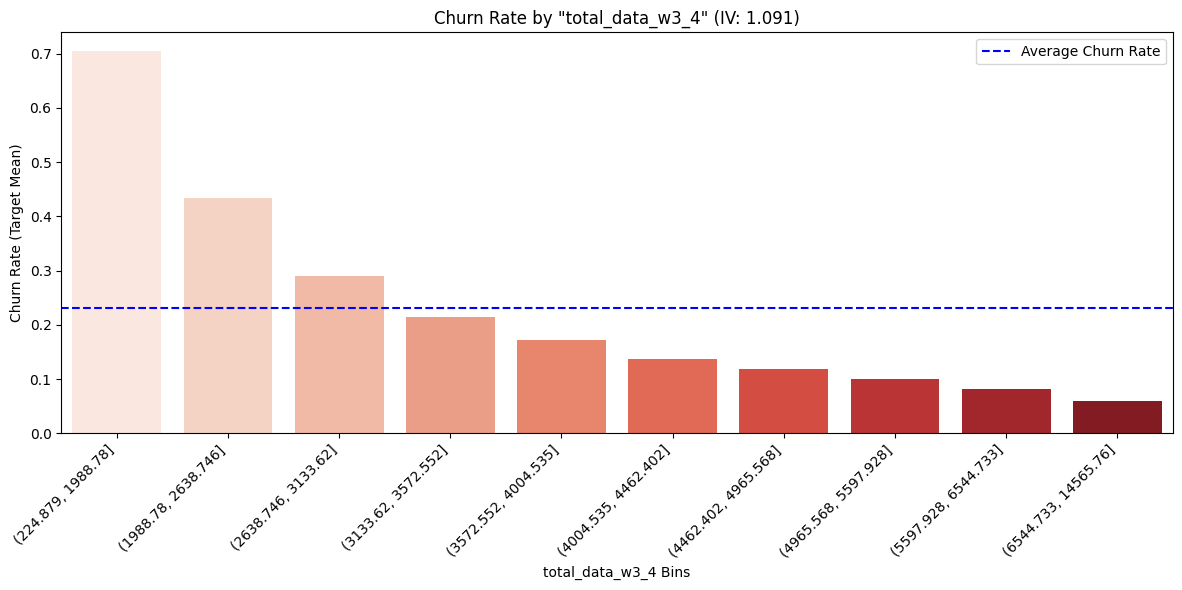

In [26]:
# Plot the #1 "Suspicious" Feature
plot_woe_analysis(train_df, 'total_data_w3_4', 'churn')

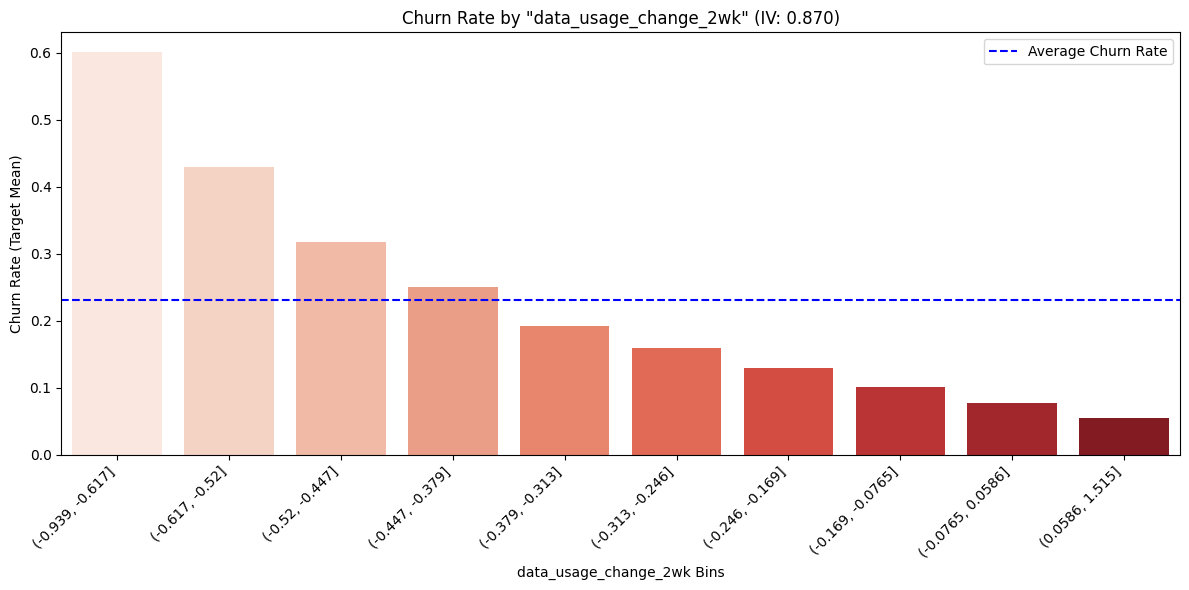

In [27]:
# Plot the #2 Feature (The "Change" Metric)
plot_woe_analysis(train_df, 'data_usage_change_2wk', 'churn')

### Weight of Evidence Analysis Summary
**Objective:** Validate the relationship between high-IV features and churn risk.

**Method:** Analyzed Churn Rate across decile bins for Top Features (`total_data_w3_4` and `data_usage_change_2wk`).

**Key Findings:**
* **Monotonic Trends:** Both features exhibit a clear **"Staircase" pattern**, verifying a monotonic relationship.
    * **Volume:** Higher data usage consistently correlates with lower churn rates across all bins.
    * **Trend:** The `change` metric is highly sensitive; deeper negative changes (drops in usage) correspond to progressively higher churn rates.
* **Interpretation:** This confirms the "Gradual Disengagement" hypothesis (in Section 2.4). Churn is not a sudden event but a measurable decline in engagement during Days 15-28.
* **Modeling Implication:** The linearity of these trends suggests these features will perform exceptionally well in linear models (Logistic Regression) without requiring complex non-linear transformations.

# 2.6 Segmentation via UMAP

Preparing Customer Segmentation Map...
Mapping based on Top 20 Features: ['total_data_w3_4', 'data_usage_change_2wk', 'usage_app_facebook_daily_std_dev_w3_4', 'usage_voice_d2d_incoming_std_dev_w3_4', 'usage_app_whatsapp_daily_std_dev_w3_4', 'usage_pack_vas_std_dev_w3_4', 'usage_app_helakuru_daily_std_dev_w3_4', 'usage_pack_data_std_dev_w3_4', 'usage_voice_d2d_outgoing_std_dev_w3_4', 'usage_app_other_std_dev_w3_4', 'usage_voice_nd2d_incoming_std_dev_w3_4', 'usage_app_tiktok_daily_std_dev_w3_4', 'usage_voice_d2nd_outgoing_std_dev_w3_4', 'usage_app_youtube_daily_std_dev_w3_4', 'usage_pack_vas_median_w1_2', 'video_data_w3_4', 'usage_voice_d2d_incoming_median_w1_2', 'usage_app_youtube_daily_median_w1_2', 'usage_voice_nd2d_incoming_median_w1_2', 'usage_app_other_median_w1_2']


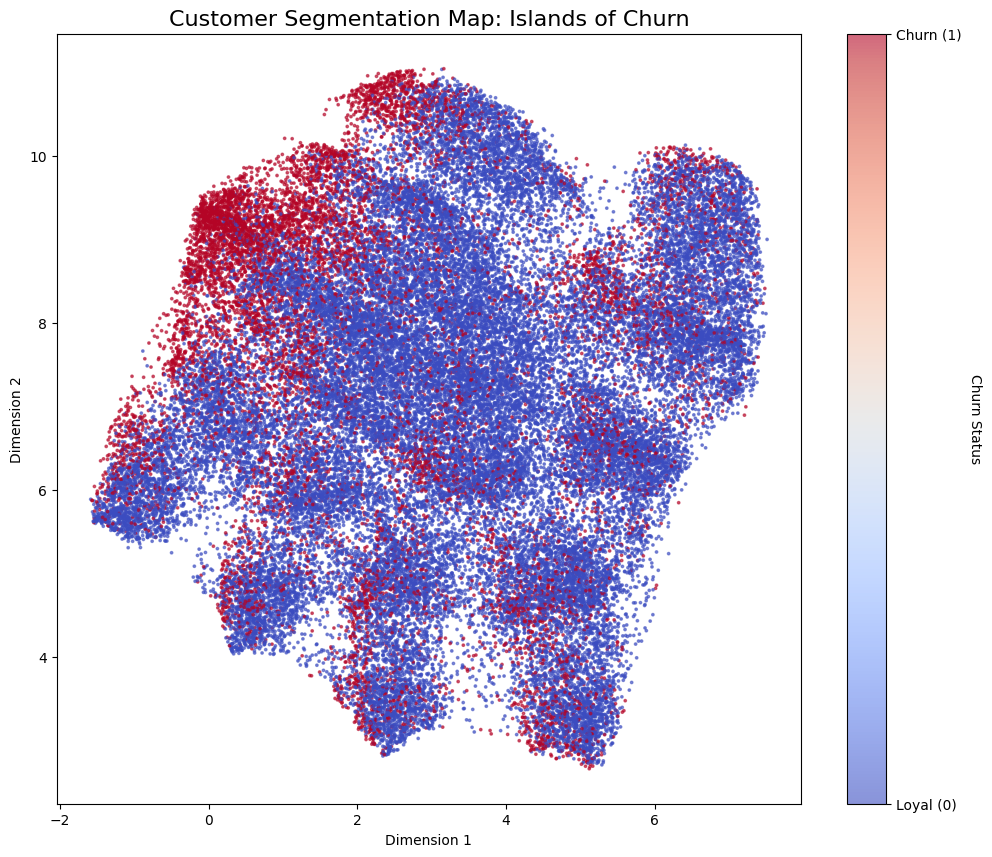

In [21]:
print("Preparing Customer Segmentation Map...")

# Feature Selection: Use the Top 20 features from ySection 2.4
top_20_features = feature_rankings['Feature'].head(20).tolist()
print(f"Mapping based on Top 20 Features: {top_20_features}")

# reprocessing: Scale the data (Critical for UMAP)
X_segmentation = train_df[top_20_features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segmentation)

# Run UMAP Projection
# n_neighbors=30: Balances local clusters with global structure
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(X_scaled)

# Prepare Data for Plotting (The Shuffle Trick)
# Combine the coordinates with the Churn label, then SHUFFLE them.
# This ensures Red dots aren't hidden behind the massive pile of Blue dots.
plot_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])
plot_df['churn'] = train_df['churn'].values
plot_df_shuffled = plot_df.sample(frac=1, random_state=42) # Shuffle 100% of rows

# The Final "Money Plot"
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    plot_df_shuffled['UMAP_1'], 
    plot_df_shuffled['UMAP_2'], 
    c=plot_df_shuffled['churn'], 
    cmap='coolwarm',  # Cool (Blue) = 0, Warm (Red) = 1
    s=3,              # Dot size
    alpha=0.6         # Transparency
)

# Formatting
plt.title('Customer Segmentation Map: Islands of Churn', fontsize=16)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Custom Legend
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Loyal (0)', 'Churn (1)'])
cbar.set_label('Churn Status', rotation=270, labelpad=15)

plt.show()

In [ ]:
# The Final "Money Plot"
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    plot_df_shuffled['UMAP_1'][plot_df_shuffled['churn'] == 1], 
    plot_df_shuffled['UMAP_2'][plot_df_shuffled['churn'] == 1], 
    c=plot_df_shuffled['churn'][plot_df_shuffled['churn'] == 1], 
    cmap='coolwarm',  # Cool (Blue) = 0, Warm (Red) = 1
    s=3,              # Dot size
    alpha=0.6         # Transparency
)

# Formatting
plt.title('Customer Segmentation Map: Islands of Churn', fontsize=16)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Custom Legend
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Loyal (0)', 'Churn (1)'])
cbar.set_label('Churn Status', rotation=270, labelpad=15)

plt.show()

In [23]:
plot_df_shuffled['UMAP_1'][plot_df_shuffled['churn'] == 1]

13604    0.916617
3263     5.155317
2494     6.092785
38288    2.529528
7220     0.853700
           ...   
1685     5.140585
16023    4.419281
21962    1.317215
6265    -1.229115
38158    0.447586
Name: UMAP_1, Length: 12022, dtype: float32

Preparing for UMAP Projection...
Using Top 20 Features: ['total_data_w3_4', 'data_usage_change_2wk', 'usage_app_facebook_daily_std_dev_w3_4', 'usage_voice_d2d_incoming_std_dev_w3_4', 'usage_app_whatsapp_daily_std_dev_w3_4', 'usage_pack_vas_std_dev_w3_4', 'usage_app_helakuru_daily_std_dev_w3_4', 'usage_pack_data_std_dev_w3_4', 'usage_voice_d2d_outgoing_std_dev_w3_4', 'usage_app_other_std_dev_w3_4', 'usage_voice_nd2d_incoming_std_dev_w3_4', 'usage_app_tiktok_daily_std_dev_w3_4', 'usage_voice_d2nd_outgoing_std_dev_w3_4', 'usage_app_youtube_daily_std_dev_w3_4', 'usage_pack_vas_median_w1_2', 'video_data_w3_4', 'usage_voice_d2d_incoming_median_w1_2', 'usage_app_youtube_daily_median_w1_2', 'usage_voice_nd2d_incoming_median_w1_2', 'usage_app_other_median_w1_2']


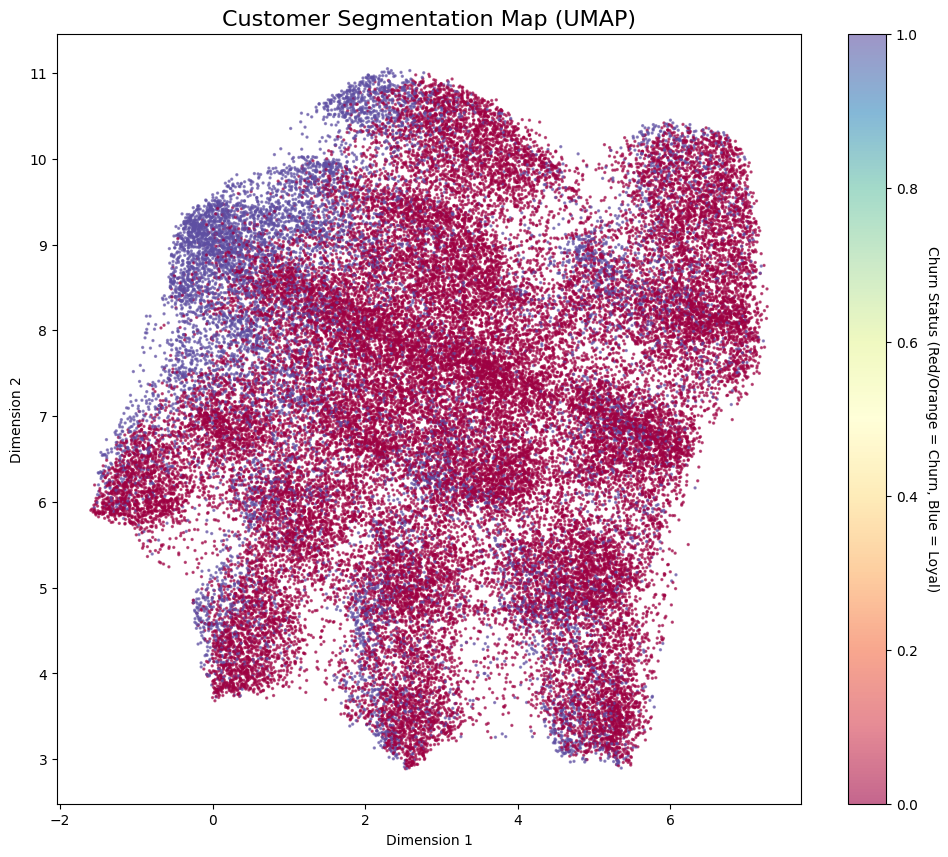

In [19]:
print("Preparing for UMAP Projection...")

# Select the Top 20 Features from Section 2.4
top_20_features = feature_rankings['Feature'].head(20).tolist()
print(f"Using Top 20 Features: {top_20_features}")

# Prepare Data (Handle NaNs and Scale)
# UMAP requires Scaled Data (Mean=0, Std=1)
X_segmentation = train_df[top_20_features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segmentation)

# Run UMAP
# n_neighbors=30: Balances local groups vs global structure
# min_dist=0.1: How tightly to pack points together
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(X_scaled)

# The Money Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=train_df['churn'], 
    cmap='Spectral', 
    s=2,           # Dot size (keep small for 70k rows)
    alpha=0.6      # Transparency (helps see density)
)
plt.title('Customer Segmentation Map (UMAP)', fontsize=16)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Create a custom legend
cbar = plt.colorbar(scatter)
cbar.set_label('Churn Status (Red/Orange = Churn, Blue = Loyal)', rotation=270, labelpad=15)

plt.show()